# 感谢阅读！本设计构建LSTM模型，以预测水稻产量。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

2.0.0-beta1


In [2]:
train_weather_path = "../data/train_weather.csv"
train_rice_path = "../data/train_rice.csv"
testA_path = "../data/testA.csv"
testB_path = "../data/testB.csv"

In [3]:
r_df = pd.read_csv(train_rice_path, encoding='gbk')
print(r_df.shape)
r_df.head()

(81, 7)


,区县id,2015年早稻,2016年早稻,2017年早稻,2015年晚稻,2016年晚稻,2017年晚稻
0,county1,15.812589,15.878158,15.835681,15.754182,15.740001,15.636155
1,county2,16.658008,16.623931,16.555916,16.666867,16.686079,16.583385
2,county3,15.206326,15.085393,15.049788,15.177311,14.995996,14.889857
3,county4,15.352061,15.311764,15.236604,15.020413,15.005488,14.882306
4,county5,15.942749,15.943796,15.876010,16.019721,15.989249,15.905980


# ！！！！！！！！！！！！注意！！！！！！！！！！！！！！！！！！

程序每次运行只针对早稻、晚稻中的一种构建模型并预测

要预测早稻： is_zao = True

要预测晚稻： is_zao = False

预测完一种，再要预测另外一种时，务必修改is_zao，并重启kernel

In [4]:
is_zao = True    # True   or    False

def get_ycr(cid,year):
    '''获取某年·某县的早/晚水稻产量'''
    r_ci = r_df[r_df.区县id == cid]
    if is_zao:
        year = str(year)+'年早稻'  
    else:
        year = str(year)+'年晚稻'    
    
    return r_ci[year].values[0]

get_ycr(cid='county1',year=2017)

15.83568061

In [5]:
dtypes = {   '区县id': object,
             '站名id': np.int64,
             '年份':   np.int64,
             '月份':   np.int64,
             '日期':   np.int64,
             '日照时数（单位：h)': np.float64,
             '02时风向': object,
             '08时风向': object,
             '14时风向': object,
             '20时风向': object,
             '日平均风速(单位：m/s)':   np.float64,
             '日降水量（mm）':          np.float64,
             '日最高温度（单位：℃）':  np.float64,
             '日最低温度（单位：℃）':  np.float64,
             '日平均温度（单位：℃）':  np.float64,
             '日相对湿度（单位：%）':   np.float64,
             '日平均气压（单位：hPa）': np.float64}
na_values =['*','/']
w_df = pd.read_csv(train_weather_path,dtype=dtypes, na_values=na_values,encoding='gbk').fillna(0)
w_df.columns = ['CountyID',  'StationID',   'Year',    'Month',    'Day',           'Hours',
                'F02',        'F08',          'F14',     'F20',      'WindS',
                'Rain',      'HighT',       'LowT',    'MeanT',    'Humidity',      'Pressure']

w_df.head(8)

,CountyID,StationID,Year,Month,Day,Hours,F02,F08,F14,F20,WindS,Rain,HighT,LowT,MeanT,Humidity,Pressure
0,county25,1,2015,1,1,6.3,NNW,N,NNE,S,1.8,0.0,14.1,7.2,9.1,43.0,980.6
1,county25,1,2015,1,2,8.1,SSE,S,SSW,S,1.3,0.0,18.3,1.6,7.5,64.0,977.7
2,county25,1,2015,1,3,4.3,S,SSE,S,SSE,2.0,0.0,18.9,2.4,9.4,66.0,973.1
3,county25,1,2015,1,4,0.0,WNW,SSW,S,SSE,2.2,0.3,14.9,9.0,11.5,76.0,966.7
4,county25,1,2015,1,5,0.0,SSE,S,SSW,C,2.8,0.8,16.8,11.6,15.5,91.0,963.9
5,county25,1,2015,1,6,0.0,NNW,N,N,NNE,3.1,1.8,15.5,7.0,9.4,85.0,972.0
6,county25,1,2015,1,7,0.0,N,N,NNW,N,3.3,2.2,8.0,5.3,6.5,82.0,978.4
7,county25,1,2015,1,8,0.0,C,ESE,N,N,1.4,0.0,9.3,4.0,6.6,80.0,981.1


# 观察天气数据

,StationID,Year,Month,Day,Hours,WindS,Rain,HighT,LowT,MeanT,Humidity,Pressure
count,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000
mean,1.032967,2016.499658,6.522930,15.729637,3.998068,1.855398,4.748059,25.785234,18.326228,21.251495,79.291340,987.946806
std,0.178551,1.117732,3.448716,8.800125,3.816964,0.995422,13.537010,7.458326,6.529348,6.706216,10.999075,26.817578
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.500000,-5.500000,-2.400000,0.000000,0.000000
25%,1.000000,2016.000000,4.000000,8.000000,0.000000,1.200000,0.000000,20.500000,13.200000,16.000000,73.000000,983.300000
50%,1.000000,2016.000000,7.000000,16.000000,3.200000,1.600000,0.000000,27.400000,19.800000,22.800000,81.000000,994.100000
75%,1.000000,2017.000000,10.000000,23.000000,7.500000,2.300000,2.400000,31.900000,24.000000,26.800000,87.000000,1002.600000
max,2.000000,2018.000000,12.000000,31.000000,13.000000,12.600000,335.500000,41.600000,30.700000,34.300000,100.000000,1035.200000


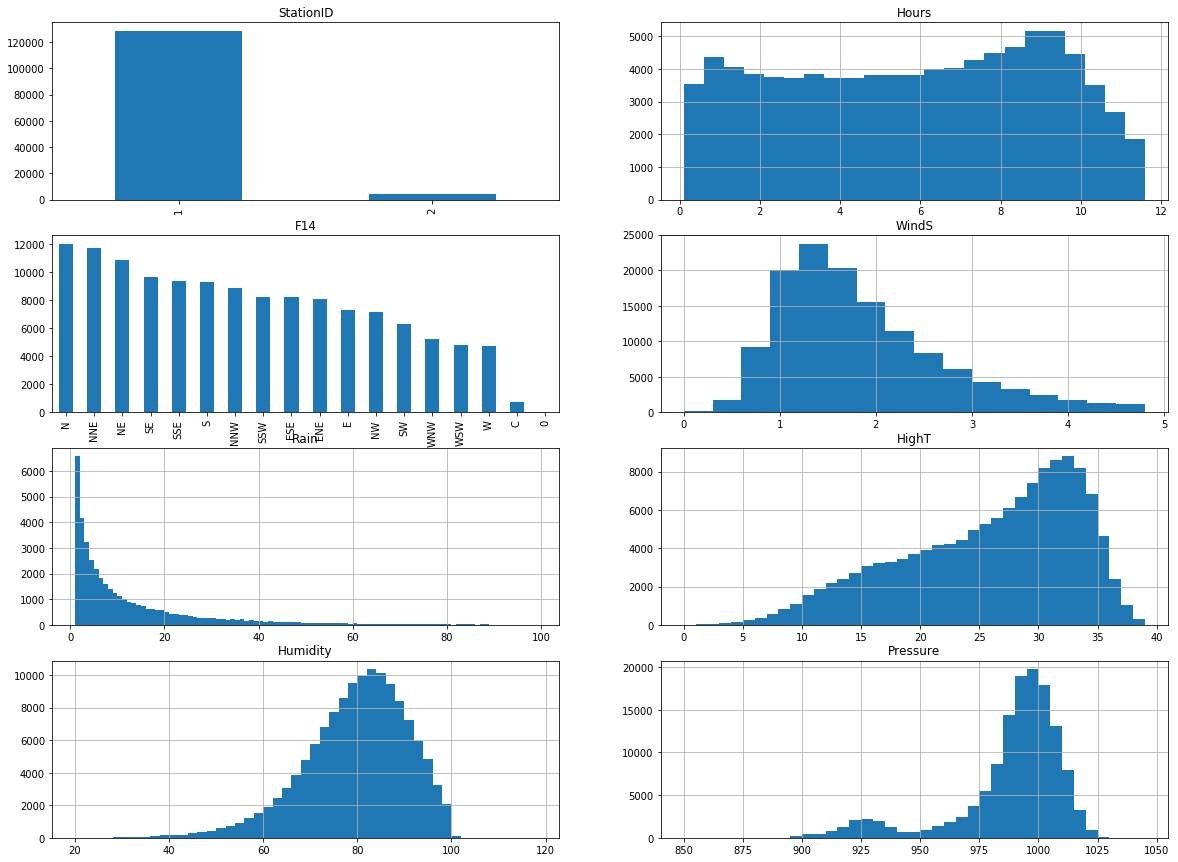

In [6]:
ww_ci_yi = w_df

plt.figure(figsize=(20,15))
plt.subplot(421)
ww_ci_yi['StationID'].value_counts().plot(kind='bar',)
plt.title('StationID')

plt.subplot(422)
ww_ci_yi['Hours'].hist(bins=np.arange(0.1,12,0.5))
plt.title('Hours')

plt.subplot(423)
ww_ci_yi['F14'].value_counts().plot(kind='bar',)
plt.title('F14')

plt.subplot(424)
ww_ci_yi.WindS.hist(bins=np.arange(0,5,0.3))
plt.title('WindS')

plt.subplot(425)
ww_ci_yi['Rain'].hist(bins=np.arange(1,100,1))   # 0 值太多，观察1到100即可
plt.title('Rain')

plt.subplot(426)
ww_ci_yi.HighT.hist(bins=np.arange(0,40,1))
plt.title('HighT')

plt.subplot(427)
ww_ci_yi.Humidity.hist(bins=np.arange(20,120,2))
plt.title('Humidity')

plt.subplot(428)
ww_ci_yi.Pressure.hist(bins=np.arange(850,1050,5))
plt.title('Pressure')


ww_ci_yi.describe()

#station == 1

# 归一化连续特征列

In [7]:
# def z_map(column):
#     cmean = column.mean(axis = 0)
#     cstd = column.std(axis = 0)
#     cmax = column.max(axis = 0)
#     #print('mean:%s\tstd:%s\tmax:%s\t'%(cmean,cstd,cmax))
#     new_column = (column - cmean) / cstd
#     return new_column

def z_map(column):
    cmax = column.max(axis=0)
    cmin = column.min(axis=0)
    new_column = (column - cmin) / (cmax - cmin)
    return new_column

need_scale_cloumns = ['Hours',  'WindS','Rain','HighT','LowT','MeanT','Humidity', 'Pressure' ]


for column in  need_scale_cloumns:
    w_df[column] = z_map(w_df[column])
    
w_df.describe()

,StationID,Year,Month,Day,Hours,WindS,Rain,HighT,LowT,MeanT,Humidity,Pressure
count,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000,132951.000000
mean,1.032967,2016.499658,6.522930,15.729637,0.307544,0.147254,0.014152,0.633068,0.658183,0.644455,0.792913,0.954354
std,0.178551,1.117732,3.448716,8.800125,0.293613,0.079002,0.040349,0.173047,0.180369,0.182731,0.109991,0.025906
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2016.000000,4.000000,8.000000,0.000000,0.095238,0.000000,0.510441,0.516575,0.501362,0.730000,0.949865
50%,1.000000,2016.000000,7.000000,16.000000,0.246154,0.126984,0.000000,0.670534,0.698895,0.686649,0.810000,0.960298
75%,1.000000,2017.000000,10.000000,23.000000,0.576923,0.182540,0.007154,0.774942,0.814917,0.795640,0.870000,0.968509
max,2.000000,2018.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 处理离散特征列

In [8]:
def parse_countyID(x,need_onehot=True): 
    '''把县的ID转换成onehot编码,县的ID由1到88中的81个数组成，在实现onehot编码时使用编码长度88'''
    length = len('county')
    cid = x[length:]
    cid_num = int(cid)
    if need_onehot:        
        cid_vec = [0]*88
        cid_vec[cid_num-1] = 1
        return cid_vec
    else:
        return cid_num

print(parse_countyID('county87'))


def fx_to_vec(x):
    '''把风向由字符转换成二维的向量，第一个维度代表水平方向，第二个维度代表竖直方向'''
    angle = np.pi / 8.

    fx_string_list = [     'E',   'ENE',   'NE',   'NNE',
                           'N',   'NNW',   'NW',   'WNW',
                           'W',   'WSW',   'SW',   'SSW',
                           'S',   'SSE',   'SE',   'ESE',   'C', 0        ]  
    # 从E(东)方向开始，逆时针转动的16个方向,无风时：‘C’   
    index = fx_string_list.index(x)
    if index < 16:
        horizontal, vertical = np.cos(index*angle), np.sin(index*angle)
    else:
        horizontal, vertical = 0., 0.
    if horizontal-0 < 1e-4:
        horizontal=0
    if vertical-0 < 1e-4:
        vertical=0
    return horizontal, vertical

fx = 'E'
fx_to_vec(fx)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


(1.0, 0)

# 获取某年·某县的天气、县ID、水稻产量，用索引代替时间特征列

In [9]:
def get_ycw(year,countyID):
    '''获取某年·某县的天气特征
    1 把每个风向由字符串表示成一个二维向量
    2 把县ID、站名ID和年月日丢弃，用归一化的索引代表时间，并只取每年的前360天
    3 保留降水量等其余特征
    结果：某年·某县的天气特征为：360*17'''
    w_ci = w_df[w_df.CountyID == countyID]
    w_ci_yi = w_ci[w_ci.Year == year]
        
    w_ci_yi = w_ci_yi.reset_index(drop=True)
    w_ci_yi = w_ci_yi[w_ci_yi.index < 360]

    for column in [ 'F02','F08','F14','F20']:
        f_s = w_ci_yi.pop(column).values          # 把 F02 的每个元素由‘N’转换成，（0，1）

        fx = []
        fy = []
        for item in f_s:
            item_vec = fx_to_vec(item)
            fx.append(item_vec[0])                 # 每个（0，1）中的第一个数字，代表风向在X方向的分量
            fy.append(item_vec[1])

        data = np.array([fx,fy])                  # 【2，360】
        data = np.transpose(data)                 # 【360，2】
        f_pd = pd.DataFrame(data=data,columns=[column+'_X',column+'_Y'])
        w_ci_yi = pd.concat([w_ci_yi,f_pd],axis=1,ignore_index=False)

    CountyID_onehot = w_ci_yi.CountyID.map(parse_countyID).values
    CountyID_onehot = np.stack(CountyID_onehot)
    w_ci_yi_17features = w_ci_yi.drop(columns=['CountyID','StationID','Year','Month','Day'])    
    w_ci_yi_17features = w_ci_yi_17features.reset_index(drop=False)
    w_ci_yi_17features['index'] = w_ci_yi_17features['index'] / 360. -0.5
    return w_ci_yi_17features.values
get_ycw(year = 2015,countyID = 'county1').shape

(360, 17)

# 81个县15-18共4年的天气特征+onehot编码的县ID：(324, 360, 17)+(324, 88)
# 81个县15-17共3年的早/晚水稻产量：(243,)

In [10]:
valid_county_ID = r_df.区县id.values

weather_list = []
countyID_list = []
rice_list = []
for year in range(2015,2018+1):
    for countyID in valid_county_ID:
        ycw = get_ycw(year,countyID)                      #  【360， 17】  
        weather_list.append(ycw)
        
        ycc = parse_countyID(countyID)                    #  【88，】     
        countyID_list.append(ycc)
        
        if year < 2018:
            ycr = get_ycr(countyID,year)           #  【1，】
            rice_list.append(ycr)
        
weather = np.stack(weather_list)
countyID = np.stack(countyID_list)
rice = np.stack(rice_list)

print(weather.shape)
print(countyID.shape)        
print(rice.shape)

(324, 360, 17)
(324, 88)
(243,)


# 获取train(15/16)/valid(17)/test(18)的Dataset

In [11]:
idx15 = list(range(81*0, 81*1))
idx16 = list(range(81*1, 81*2))
idx17 = list(range(81*2, 81*3))
idx18 = list(range(81*3, 81*4))

train_index = idx15 + idx16*2                      # 训练集：      15年 + 2倍16年
valid_index = idx17                                # 验证集：      17年
all_index   = idx15 + idx16*2 + idx17*4            # 所有数据集 ： 15年 + 2倍16年 + 4倍17年
test_index  = idx18                                # 测试集：      18年

bs = 81

train_dt = tf.data.Dataset.from_tensor_slices(
    ((weather[train_index],countyID[train_index]),rice[train_index])).repeat().shuffle(10000).batch(bs)
valid_dt = tf.data.Dataset.from_tensor_slices(
    ((weather[valid_index],countyID[valid_index]),rice[valid_index])).repeat().batch(bs)
all_dt = tf.data.Dataset.from_tensor_slices(
    ((weather[all_index],  countyID[all_index]),  rice[all_index]  )).repeat().shuffle(10000).batch(bs)

# 1 定义LSTM模型预测产量，记为：pre
# 2 用Dense模型学习产量与县ID之间的关系，用Sigmoid激活输出，记为：c
# 3 最后把pre用c进行调节，即最终预测结果：pre * c

Model: "merge_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs1 (InputLayer)            [(None, 360, 17)]    0                                            
__________________________________________________________________________________________________
Bid_1 (Bidirectional)           (None, 360, 64)      12800       inputs1[0][0]                    
__________________________________________________________________________________________________
Bid_2 (Bidirectional)           (None, 360, 64)      24832       Bid_1[0][0]                      
__________________________________________________________________________________________________
inputs2 (InputLayer)            [(None, 88)]         0                                            
________________________________________________________________________________________

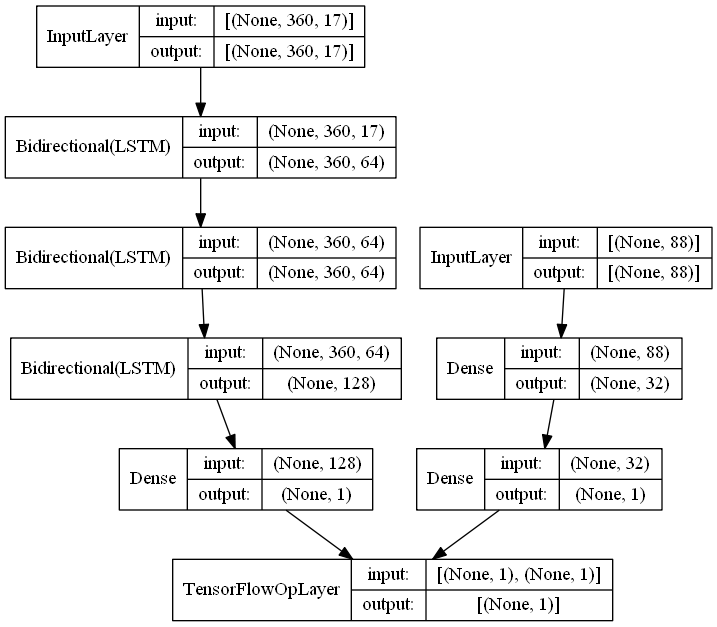

In [12]:
def build_and_compile_model():
    inputs1 = tf.keras.Input(shape=(360,17),name='inputs1')
    inputs2 = tf.keras.Input(shape=(88,),name='inputs2')
    L2 = tf.keras.regularizers.l2(1e-4)
    ##############################################################################################################
    lstm1 = keras.layers.Bidirectional(
           layers.LSTM(32,  kernel_regularizer=L2,
                            recurrent_regularizer=L2,
                            bias_regularizer=L2,
                            recurrent_initializer='glorot_uniform',
                            return_sequences=True,
                            name='lstm1'),
                                        merge_mode='concat',
                                        name='Bid_1')(inputs1)
    lstm2 = keras.layers.Bidirectional(
           layers.LSTM(32,  kernel_regularizer=L2,
                            recurrent_regularizer=L2,
                            bias_regularizer=L2,
                            recurrent_initializer='glorot_uniform',
                            return_sequences=True,
                            name='lstm2'),
                                        merge_mode='concat',
                                        name='Bid_2')(lstm1)
    
    lstm3 = keras.layers.Bidirectional(
           layers.LSTM(64,  kernel_regularizer=L2,
                            recurrent_regularizer=L2,
                            bias_regularizer=L2,
                            recurrent_initializer='glorot_uniform',
                            return_sequences=False,
                            name='lstm3'),
                                        merge_mode='concat',
                                        name='Bid_3')(lstm2)    
    ##############################################################################################################
    pre = layers.Dense(     units = 1,                      
                            kernel_initializer='glorot_uniform',
                            kernel_regularizer=L2,                 
                            name='predict')(lstm3)
    ##############################################################################################################
    county_condition1 = layers.Dense(32,
                                    activation='tanh', 
                                    name='county_condition1')(inputs2)
    county_condition2 = layers.Dense(1,
                                    activation='sigmoid', 
                                    name='county_condition2')(county_condition1)
    contrl_pre = tf.multiply(pre,   county_condition2, name='contrl_pre',)   # 使用countyID 约束 预测的产量
    
    merge_model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=contrl_pre, name='merge_model')
    ##############################################################################################################
    merge_model.compile( optimizer=tf.keras.optimizers.Adam(),
                         loss=tf.keras.losses.Huber(),
                         metrics = [tf.keras.metrics.mse])
    return merge_model

merge_model = build_and_compile_model()
merge_model.summary()
plot_model( merge_model,
            show_shapes=True, 
            show_layer_names=0, 
            rankdir='TB',
            to_file='../user_data/merge_model.png',
       
          )

# 用15/16做训练，17做验证

In [13]:
# merge_model.load_weights('../user_data/merge_model.h5')
cbk = tf.keras.callbacks.EarlyStopping(     monitor='val_mean_squared_error',
                                            min_delta=0,   # 忽略
                                            patience=100,
                                            verbose=1,
                                            mode='min',
                                            baseline=None,
                                            restore_best_weights=True,)


merge_model_h = merge_model.fit(train_dt,     epochs=1000,         steps_per_epoch  = len(train_index)//bs,
                                validation_data=valid_dt,          validation_steps = 1,
                                callbacks=[cbk] )

Epoch 1/1000


W0928 19:35:03.429138  3436 deprecation.py:323] From C:\Users\gang_E540\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/3 [==============================] - 12s 4s/step - loss: 14.2984 - mean_squared_error: 219.3078 - val_loss: 13.9891 - val_mean_squared_error: 210.6390
Epoch 2/1000
3/3 [==============================] - 1s 287ms/step - loss: 13.8720 - mean_squared_error: 206.6635 - val_loss: 13.3841 - val_mean_squared_error: 193.5441
Epoch 3/1000
3/3 [==============================] - 1s 291ms/step - loss: 13.2316 - mean_squared_error: 189.4170 - val_loss: 12.5212 - val_mean_squared_error: 170.4837
Epoch 4/1000
3/3 [==============================] - 1s 288ms/step - loss: 12.1135 - mean_squared_error: 161.4819 - val_loss: 11.6240 - val_mean_squared_error: 148.1053
Epoch 5/1000
3/3 [==============================] - 1s 285ms/step - loss: 11.1557 - mean_squared_error: 137.4165 - val_loss: 10.7974 - val_mean_squared_error: 128.9152
Epoch 6/1000
3/3 [==============================] - 1s 283ms/step - loss: 10.7578 - mean_squared_error: 127.8134 - val_loss: 10.0116 - val_mean_squared_error: 111.9369
Epoch 7

4/4 [==============================] - 0s 108ms/step - loss: 0.0846 - mean_squared_error: 0.0107


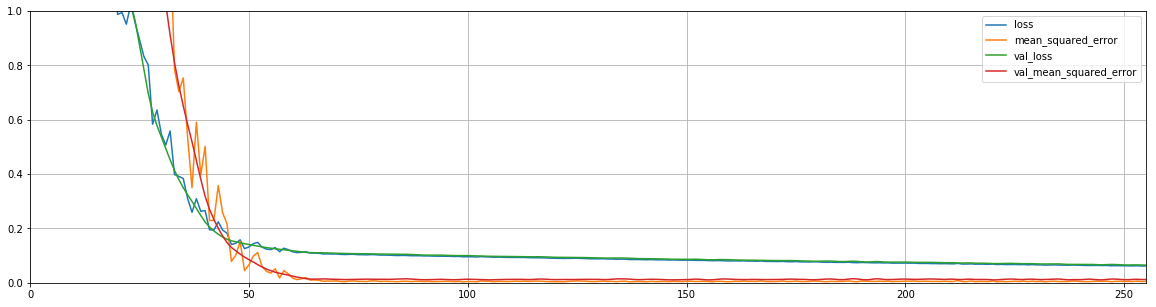

In [14]:
merge_model.evaluate(train_dt,steps =  2*6)
merge_model.evaluate(valid_dt,steps =  1*4)

def plot_learning_history(history,y_max):
    pd.DataFrame(history.history).plot(figsize=(20,5))
    plt.grid(True)
    plt.gca().set_ylim(0, y_max)
    plt.show()
    
try:
    plot_learning_history(merge_model_h,1)
except NameError as Error:
    print(Error)

# 用15/16/17三年数据训练

In [15]:
merge_model_h = merge_model.fit(all_dt,  epochs=1000,          steps_per_epoch  = len(all_index)//bs,
                                validation_data=valid_dt,      validation_steps = 1,
                                callbacks=[cbk] )

Epoch 1/1000
7/7 [==============================] - 2s 306ms/step - loss: 0.0824 - mean_squared_error: 0.0067 - val_loss: 0.0813 - val_mean_squared_error: 0.0052
Epoch 2/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.0811 - mean_squared_error: 0.0055 - val_loss: 0.0800 - val_mean_squared_error: 0.0040
Epoch 3/1000
7/7 [==============================] - 2s 260ms/step - loss: 0.0802 - mean_squared_error: 0.0050 - val_loss: 0.0784 - val_mean_squared_error: 0.0022
Epoch 4/1000
7/7 [==============================] - 2s 260ms/step - loss: 0.0801 - mean_squared_error: 0.0063 - val_loss: 0.0779 - val_mean_squared_error: 0.0026
Epoch 5/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.0788 - mean_squared_error: 0.0051 - val_loss: 0.0768 - val_mean_squared_error: 0.0020
Epoch 6/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.0780 - mean_squared_error: 0.0048 - val_loss: 0.0764 - val_mean_squared_error: 0.0024
Epoch 7/1000
7/7 [==========

4/4 [==============================] - 0s 111ms/step - loss: 0.0145 - mean_squared_error: 0.0011


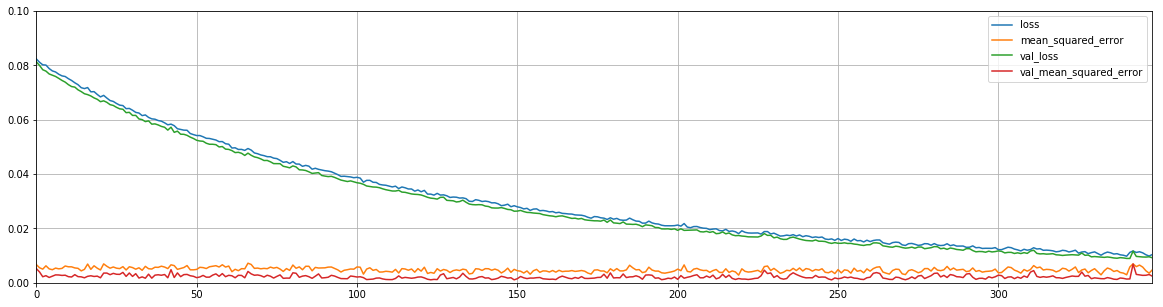

In [16]:
merge_model.evaluate(train_dt,steps =  2*4)
merge_model.evaluate(valid_dt,steps =  1*4)
   
try:
    plot_learning_history(merge_model_h,0.1)
except NameError as Error:
    print(Error)

In [17]:
merge_model.save_weights('../user_data/merge_model.h5')

# 预测2018年水稻产量

In [18]:
pred_test_y = merge_model.predict( (weather[test_index],countyID[test_index]))
pred_test_y_1D = pred_test_y.reshape(-1)
data = np.stack([valid_county_ID,pred_test_y_1D],axis=1)
df = pd.DataFrame(data)
df.head(8)

,0,1
0,county1,15.9229
1,county2,16.6097
2,county3,15.1466
3,county4,15.3153
4,county5,15.9241
5,county6,17.3935
6,county7,17.2663
7,county8,12.7945


In [19]:
df.to_csv('../prediction_result/result.csv', index=False,header=False,)